# Example: Sequential Monte Carlo Filtering

This example is from the Pyro documentation:
- https://pyro.ai/examples/smcfilter.html

Copyright (c) 2017-2019 Uber Technologies, Inc.
SPDX-License-Identifier: Apache-2.0

This file demonstrates how to use the SMCFilter algorithm with
a simple model of a noisy harmonic oscillator of the form:

    z[t] ~ N(A*z[t-1], B*sigma_z)
    y[t] ~ N(z[t][0], sigma_y)
    

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import SMCFilter
from control import StateSpace, step_response, InputOutputSystem

In [8]:
# Arguments - defaults
class args:
    pass

args.num_timesteps = 500  # number of timesteps
args.num_particles = 100  # number of particles
args.process_noise = 1
args.measurement_noise = 1
args.seed = 0

In [9]:
# Demonstrate model
A = [[0.0, 1.0], [-1.0, 0.0]]
B = [[3.0], [3.0]]
C = [[1.0, 0]]
D = 0
Ts = 1
sys = StateSpace(A, B, C, D, Ts)
sys

StateSpace(array([[ 0.,  1.],
       [-1.,  0.]]), array([[3.],
       [3.]]), array([[1., 0.]]), array([[0.]]), 1)

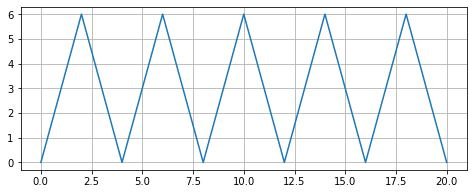

In [10]:
r_step = step_response(sys)
plt.figure(figsize=(8,3))
plt.plot(r_step.t, r_step.y[0,0])
plt.grid()
plt.show()

In [11]:
class SimpleHarmonicModel:
    def __init__(self, process_noise, measurement_noise):
        self.A = torch.tensor([[0.0, 1.0], [-1.0, 0.0]])
        self.B = torch.tensor([3.0, 3.0])
        self.sigma_z = torch.tensor(process_noise)
        self.sigma_y = torch.tensor(measurement_noise)

    def init(self, state, initial):
        self.t = 0
        state["z"] = pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1
        state["z"] = pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(state["z"].matmul(self.A), self.B * self.sigma_z).to_event(1),
        )
        y = pyro.sample(
            "y_{}".format(self.t), dist.Normal(state["z"][..., 0], self.sigma_y), obs=y
        )
        return state["z"], y


class SimpleHarmonicModel_Guide:
    def __init__(self, model):
        self.model = model

    def init(self, state, initial):
        self.t = 0
        pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1

        # Proposal distribution
        pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(
                state["z"].matmul(self.model.A), torch.tensor([1.0, 1.0])
            ).to_event(1),
        )


In [12]:
def generate_data(args):
    model = SimpleHarmonicModel(args.process_noise, args.measurement_noise)

    state = {}
    initial = torch.tensor([1.0, 0.0])
    model.init(state, initial=initial)
    zs = [initial]
    ys = [None]
    for t in range(args.num_timesteps):
        z, y = model.step(state)
        zs.append(z)
        ys.append(y)

    return zs, ys

In [13]:
pyro.set_rng_seed(args.seed)

model = SimpleHarmonicModel(args.process_noise, args.measurement_noise)
guide = SimpleHarmonicModel_Guide(model)

smc = SMCFilter(model, guide, num_particles=args.num_particles, max_plate_nesting=0)

print("Generating data")
zs, ys = generate_data(args)

print("Filtering")

smc.init(initial=torch.tensor([1.0, 0.0]))
for y in ys[1:]:
    smc.step(y)

z = smc.get_empirical()["z"]

print("At final time step:")
print(f"truth: {zs[-1]}")
print(f"mean: {z.mean}")
print(f"std: {z.variance**0.5}")

Generating data
Filtering
At final time step:
truth: tensor([ 0.0809, 67.0811])
mean: tensor([-1.1345, 65.9661])
std: tensor([0.8514, 1.6066])


## RODD disturbance

In [14]:
class Model:
    def __init__(self, sigma_wp, measurement_noise):
        self.A = torch.tensor([[0.7, 1.0], [0.0, 1.0]])
        self.B = torch.tensor([[0], [1]])
        self.C = torch.tensor([0.3, 0.0])
        self.b = 100
        self.sigma_wp = torch.tensor([sigma_wp**2, (self.b * sigma_wp)**2])
        self.epsilon = 0.01
        self.sigma_y = torch.tensor(measurement_noise)

    def init(self, state, initial):
        self.t = 0
        state["z"] = pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1
        wp_dist = dist.Normal(torch.tensor([0.0]), self.sigma_wp[alpha])
        measurement = pyro.sample('obs', wp_dist)
        state["z"] = pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(state["z"].matmul(self.A), self.B * self.sigma_z).to_event(1),
        )
        y = pyro.sample(
            "y_{}".format(self.t), dist.Normal(state["z"][..., 0], self.sigma_y), obs=y
        )
        return state["z"], y


class Guide:
    def __init__(self, model):
        self.model = model

    def init(self, state, initial):
        self.t = 0
        pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1

        # Proposal distribution
        pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(
                state["z"].matmul(self.model.A), torch.tensor([1.0, 1.0])
            ).to_event(1),
        )



In [15]:
help(dist.Binomial.to_event)

Help on function to_event in module pyro.distributions.torch_distribution:

to_event(self, reinterpreted_batch_ndims=None)
    Reinterprets the ``n`` rightmost dimensions of this distributions
    :attr:`~torch.distributions.distribution.Distribution.batch_shape`
    as event dims, adding them to the left side of
    :attr:`~torch.distributions.distribution.Distribution.event_shape`.
    
    Example:
    
        .. doctest::
           :hide:
    
           >>> d0 = dist.Normal(torch.zeros(2, 3, 4, 5), torch.ones(2, 3, 4, 5))
           >>> [d0.batch_shape, d0.event_shape]
           [torch.Size([2, 3, 4, 5]), torch.Size([])]
           >>> d1 = d0.to_event(2)
    
        >>> [d1.batch_shape, d1.event_shape]
        [torch.Size([2, 3]), torch.Size([4, 5])]
        >>> d2 = d1.to_event(1)
        >>> [d2.batch_shape, d2.event_shape]
        [torch.Size([2]), torch.Size([3, 4, 5])]
        >>> d3 = d1.to_event(2)
        >>> [d3.batch_shape, d3.event_shape]
        [torch.Size([]), t